In [1]:
#
# Valuation European Call Options in BSM Model
# Comparison of Analytical, int_valueegral and FFT (Fast Fourier Transform) Approach
#
import math
import numpy as np
from numpy.fft import fft
from scipy.integrate import quad
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

#
# Model Parameters
#
S0 = 100.00 # initial index level
K = 100.00 # strike level
T = 1. # call option maturity
r = 0.05 # constant short rate
sigma = 0.2 # constant volatility of diffusion

#
# Vvaluation y int_valueegration
#
### Analytical Formula
def BSM_call_value(S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM Model.
    --> Analytical Formula.
    
    Parameters
    =============
    S0: float
        initial stock/index level
    K:  float
        strike price
    T:  float
        time-to-maturity (for t=0)
    r:  float
        constant risk-free short rate
    sigma: float
           volatility factor in diffusion term
           
    Returns
    =========
    call_value: float
                European call option present value
                
    '''
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    BS_C = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))

    return BS_C


#
# Fourier Transform with Numerical int_valueegration
#

def BSM_call_value_INT(S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model via Lewis (2001)
    --> Fourier-based approach (integral).
    
    Parameters
    ============
    S0: float
        initial stock/index level
    K: float
       strike price
    T: float
       time-to-maturity (for t=0)
    r: float
       constant risk-free short rate
    sigma: float
           volatility factor in diffusion term
    
    Returns
    =========
    call_value: float
                European call option present value
    '''
    int_value = quad(lambda u: BSM_integral_function(u, S0, K, T, r, sigma), 0, 100)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def BSM_integral_function(u, S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model via Lewis (2001)
    --> Fourier-based approach: integral function. '''
    cf_value = BSM_characteristic_function(u -1j * 0.5, 0.0, T, r, sigma)
    int_value  = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * cf_value).real
    return int_value

def BSM_characteristic_function(v, x0, T, r, sigma):
    ''' Valuation of European call option in BSM model via Lewis (2001) and Carr-Madan (1999)
    --> Fourier-based approach: characteristic function. '''
    cf_value = np.exp(((x0 / T + r - 0.5 * sigma ** 2) * 1j * v - 0.5 * sigma ** 2 * v ** 2) * T)
    return cf_value
    

In [2]:
C0 = BSM_call_value_INT(S0, K, T, r, sigma)
print(C0)

10.450583572184797


In [11]:
#
# Fourier Transform with FFT
#

def BSM_call_value_FFT(S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model via Lewis (2001)
    --> Fourier-based approach (integral)
    
    Parameters
    ============
    S0: float
        initial stock/index level
    K: float
       strike price
    T: float
       time-to-maturity (for t=0)
    r: float
       constant risk-free short rate
    sigma: float
           volatility factor in diffusion term
    
    Returns
    =========
    call_value: float
                European call option present value
                
    '''
    
    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1 # factor to increase accuracy
    N = g * 4096
    eps = (g * 150.) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - K
    u = np.arange(1, N + 1, 1)
    v0 = eta * (u - 1)
    # Modifications to Ensure int_valueegrability
    if S0 >= 0.95  * K: # ITM case
        alpha = 1.5
        v = v0 - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (BSM_characteristic_function(v, x0, T, r, sigma) / 
                                                                   (alpha ** 2 + alpha 
                                                                    - v0 ** 2 + 1j * (2 * alpha + 1) * v0))
    else: # OTM case
        alpha = 1.1
        v = (v0 - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (1 / (1 + 1j * (v0 - 1j * alpha))
                                    - np.exp(r * T) / (1j * (v0 - 1j * alpha))
                                    - BSM_characteristic_function(v, x0, T, r, sigma) /
                                    ((v0 - 1j * alpha) ** 2 - 1j * (v0 - 1j * alpha)))
        v = (v0 + 1j * alpha) - 1j
        
        modcharFunc2 = np.exp(-r * T) * (1 / (1 + 1j * (v0 + 1j * alpha))
                                         - np.exp(r * T) / (1j * (v0 + 1j * alpha))
                                         - BSM_characteristic_function(v, x0, T, r, sigma) / 
                                         ((v0 + 1j * alpha) ** 2 - 1j * (v0 + 1j * alpha)))
        
    # Numerical FFT Routine
    delt = np.zeros(N, dtype=np.float64)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * v0) * modcharFunc * eta * SimpsonW
        payoff = (fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else: 
        FFTFunc = (np.exp(1j * b * v0)
                    * (modcharFunc1 - modcharFunc2)
                    * 0.5 * eta * SimpsonW)
        payoff = (fft(FFTFunc)).real 
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)
    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0
    # klist = np.exp((np.arange(0, N, 1) - 1) * eps - b) * S0
    return CallValue #, klist[pos - 50:pos + 50]

def plot_val_differences(vtype='int'):
    k_list = np.linspace(S0 * 0.6, S0 * 1.4, 50)
    ana_values = BSM_call_value(S0, k_list, T, r, sigma)
    plt.figure(figsize=(8, 6))
    plt.subplot(311)
    plt.plot(k_list, ana_values, 'b', label='analytical', lw=1.5)
    if vtype == 'int':
        int_values = np.array([BSM_call_value_INT(S0, K, T, r, sigma)
                               for K in k_list])
        plt.plot(k_list, int_values, 'r-.', label='Fourier (integral)', lw=1.5)
        diffs = int_values - ana_values
        rdiffs = (int_values - ana_values) / ana_values
    else:
        fft_values = np.array([BSM_call_value_FFT(S0, K, T, r, sigma)
                               for K in k_list])
        plt.plot(k_list, fft_values, 'r-.', label='Fourrier (FFT)', lw=1.5)
        diffs = fft_values - ana_values
        rdiffs = (fft_values - ana_values) / ana_values
    plt.legend()
    plt.grid()
    plt.subplot(312)
    plt.plot(k_list, diffs, 'g', label='abs. difference', lw=1.5)
    plt.legend(loc=0)
    plt.grid()
    plt.subplot(313)
    plt.plot(k_list, rdiffs, 'r', label='rel. difference', lw=1.5)
    plt.legend(loc=0)
    plt.xlabel('strike')
    plt.grid()
    plt.tight_layout()    
        

In [9]:
#C02 = BSM_call_value_FFT(S0, K, T, r, sigma)
#print(C02)

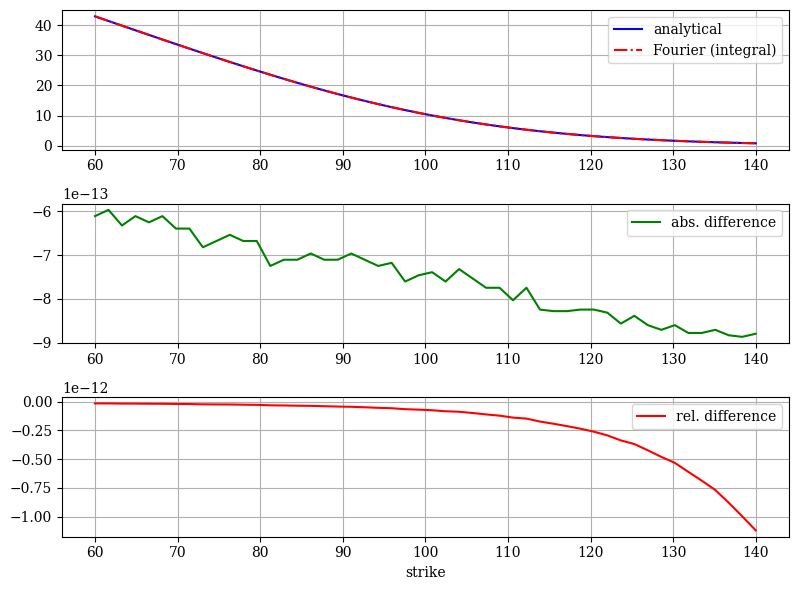

In [12]:
plot_val_differences()